In [1]:
import numpy as np
import maxflow
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import cv2

In [2]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()

#### Calculate $\beta$
 - Beta is the smoothness term for the boundary between bg and fg
 - When beta is 1, the boundary is perfectly smooth
 - beta > 0 is preferred to relax constraints on hard boundary b/w pixels
 
 $$
     \beta = \frac{1}{(2*\text{E}(\sqrt{||pixel_{i} - pixel{j}||})}
 $$
 
 Here, $\text{E}$ is the average over all pairs of neighbouring pixels in the image. which are $4wh -3h -3w +2$ in number.

In [3]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0
        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [4]:
def run(infolder, filename: str, outfolder, iters, gamma, k):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(infolder+filename)
    img2 = img.copy()                                
    mask = 10 * np.ones(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                         #                               1 - foreground pixels, 10 - initial value
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    gc = None # grab cut object
    
    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented output', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = 10 * np.ones(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
      
        elif k == 13: 
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_over'] = True
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            
            #---------------- Initialization ----------------#
        
            print('starting grabcut')
            print(FLAGS['RECT'])
            
            gc = GrabCut(img2,gamma, k, 10, FLAGS['RECT'], mask, iters)
            img_res = np.zeros(img2.shape).astype(np.uint8)
            ind = np.where(np.logical_or(gc.trimap == gc.FG, gc.trimap == gc.PR_FG))
            
            img_res[ind] = img2[ind]
            img_res = cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB)
            print('finished grabcut, select fg by pressing 1, bg by pressing 0 ')
            plt.imsave(outfolder+filename,img_res)
            display_img_arr([img_res], 1, 3, (20, 20), ['resultant img'])

        EventObj.flags = FLAGS
        mask2 = np.where((mask == 1), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2)

In [21]:
import numpy as np
import maxflow
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def display_img_arr(img_arr, r, c, dim,titles_arr):
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()
    
class GrabCut:
    def __init__(self, img, gamma, k, max_iter, bgRect, mask, iters):
        print(mask.shape)
        self.height = img.shape[1]
        self.width = img.shape[0]

        self.k = k
        self.gamma = gamma
        self.img = img.astype(np.float64)
        
        self.graph = maxflow.GraphFloat()
        self.pixels = self.graph.add_grid_nodes(self.img.shape[:2])
        
        self.set_beta()
        print("self.beta = ", self.beta)

        self.set_graph_weights()
        
        self.BG = 0 # Sure Background
        self.FG = 1 # Sure Foreground
        self.PR_BG = 2  #Probable background
        self.PR_FG = 3 #Probable foreground

        self.init_trimap(mask, bgRect)
        self.add_terminal_edges()
        self.iterative_step(iters, max_iter)
        

    def set_beta(self):
        beta = 0
        # calculates average over an image sample for (z_m-z_n)^2 for 
        self._left_diff = self.img[:, 1:] - self.img[:, :-1] # Left-difference
        self._upleft_diff = self.img[1:, 1:] - self.img[:-1, :-1] # Up-Left difference
        self._up_diff = self.img[1:, :] - self.img[:-1, :] # Up-difference
        self._upright_diff = self.img[1:, :-1] - self.img[:-1, 1:] # Up-Right difference
        # beta is as described in the paper
        beta = (self._left_diff*self._left_diff).sum() + (self._upleft_diff*self._upleft_diff).sum() \
            + (self._up_diff*self._up_diff).sum() + (self._upright_diff*self._upright_diff).sum() # According to the formula
        self.beta = 1/(2*beta/(4*self.width*self.height - 3*self.width - 3*self.height + 2))
        # 4*self.width*self.height - 3*self.width - 3*self.height + 2 is the number of pairs of neighbouring pixels in the image

    def set_graph_weights(self):
        for i in range(self.height):
            for j in range(self.width):
                current_pixel = self.pixels[j, i]
                if j-1 >= 0: # if top neighbor exists
                    dest_node = self.pixels[j-1, i]
                    temp = np.sum((self.img[j, i] - self.img[j-1, i])**2)
                    wt = np.exp(-self.beta * temp)
                    
                    n_link = self.gamma/1 * wt
                    self.graph.add_edge(current_pixel, dest_node , n_link, n_link)

                if i-1 >= 0: # if left neighbor exists
                    dest_node = self.pixels[j, i-1]
                    temp = np.sum((self.img[j, i] - self.img[j, i-1])**2)
                    wt = np.exp(-self.beta * temp)
                    n_link = self.gamma/1 * wt
                    self.graph.add_edge(current_pixel, dest_node, n_link, n_link)
                
                if i-1 >= 0 and j-1 >= 0: # if top left neighbor exists
                    dest_node  = self.pixels[j-1, i-1]
                    temp = np.sum((self.img[j, i] - self.img[j-1, i-1])**2)
                    wt = np.exp(-self.beta * temp )
                    n_link = self.gamma/np.sqrt(2) * wt
                    self.graph.add_edge(current_pixel, dest_node, n_link, n_link)
                
                if i+1 < self.height and j-1 >= 0: # if top right neighbor exists
                    temp = np.sum((self.img[j, i] - self.img[j-1, i+1])**2)
                    wt = np.exp(-self.beta * temp)
                    n_link = self.gamma/np.sqrt(2) * wt
                    self.graph.add_edge(current_pixel, dest_node, n_link, n_link)


    def init_trimap(self, mask, bgRect):
        self.bgRect = bgRect
        x, y, w, h = bgRect
        temp  = np.ones(shape = self.img.shape[:2])

       
        self.trimap = self.BG * temp # Initially all trimap background
        self.trimap[np.where(mask == 0)] = self.BG # Sure background
        y_start = y
        y_end = y_start+h+1
        x_start = x
        x_end = x_start+w+1

        self.trimap[y_start:y_end, x_start:x_end] = self.PR_FG # trimap unknown set
        self.trimap[np.where(mask == 1)] = self.FG # Sure foreground

    def add_terminal_edges(self):
        x, y = np.where(self.trimap == self.FG)

        for i in range(len(x)):
            x_i = x[i]
            y_i = y[i]
            edge = self.pixels[x_i, y_i]
            self.graph.add_tedge(edge, np.inf, 0)
        
        x, y = np.where(self.trimap == self.BG)
        
        for i in range(len(x)):
            x_i = x[i]
            y_i = y[i]
            edge = self.pixels[x_i, y_i]
            self.graph.add_tedge(edge, 0, np.inf)

    def set_cov_inv(self):
        self.cov_inv_fg =  np.linalg.inv(self.fg_gmm.covariances_)
        self.cov_inv_bg =  np.linalg.inv(self.bg_gmm.covariances_)

    def set_cov_det(self):
        self.bg_cov_det = np.linalg.det(self.bg_gmm.covariances_)
        self.fg_cov_det = np.linalg.det(self.fg_gmm.covariances_)

    def set_kmeans(self, max_iter):
        self.bg_kmeans = KMeans(n_clusters=self.k, max_iter = max_iter)
        self.fg_kmeans = KMeans(n_clusters=self.k, max_iter = max_iter)

    def set_gmm(self):
        self.bg_gmm = GaussianMixture(n_components = self.k)
        self.fg_gmm = GaussianMixture(n_components = self.k)

    def iterative_step(self, iters, max_iter):
        for i in range(iters):
            print(f"Iteration {i+1}")
            bg_indices = np.where(np.logical_or(self.trimap == self.BG, self.trimap == self.PR_BG))
            fg_indices = np.where(np.logical_or(self.trimap == self.FG, self.trimap == self.PR_FG))

            bg_set = self.img[bg_indices]
            fg_set = self.img[fg_indices]


            self.set_kmeans(max_iter)
            BG_GMM = np.empty(shape = len(bg_set), dtype = int)
            FG_GMM = np.empty(shape = len(fg_set), dtype = int)

            BG_KM = self.fg_kmeans.fit(bg_set) # K Means for background pixels
            FG_KM = self.fg_kmeans.fit(fg_set) # K Means for foreground pixels
            
            self.set_gmm()

            self.bg_gmm.fit(bg_set, BG_KM.labels_)
            self.fg_gmm.fit(fg_set, FG_KM.labels_)
           
            BG_GMM = self.bg_gmm.predict(bg_set)
            FG_GMM = self.fg_gmm.predict(fg_set)

            self.bg_gmm.fit(bg_set, BG_GMM)
            self.fg_gmm.fit(fg_set, FG_GMM)

            self.set_cov_det()

            D_bg = self.bg_gmm.weights_ / np.sqrt(self.bg_cov_det)
            D_fg = self.fg_gmm.weights_ / np.sqrt(self.fg_cov_det)
            
            self.set_cov_inv()
            tedge_weights_bg = np.empty(shape = (self.img.shape[0],self.img.shape[1]),dtype = np.float64)
            tedge_weights_fg = np.empty(shape = (self.img.shape[0],self.img.shape[1]), dtype = np.float64)
            
            r_ind, c_ind = np.where(np.logical_or(self.trimap == self.PR_BG, self.trimap == self.PR_FG))
            
            for k in range(len(r_ind)):
                node = self.img[r_ind[k], c_ind[k]]
                D_BG = 0
                D_FG = 0
                for j in range(self.k):
                    bg_u = self.bg_gmm.means_[j]
                    fg_u = self.fg_gmm.means_[j]
                    D_BG += D_bg[j] * np.exp(-0.5 * (node - bg_u).reshape(1, 3) @ self.cov_inv_bg[j] @ (node - bg_u).reshape(3, 1))[0][0] 
                    D_FG += D_fg[j] * np.exp(-0.5 * (node - fg_u).reshape(1, 3) @ self.cov_inv_fg[j] @ (node - fg_u).reshape(3, 1))[0][0]

                tedge_weights_fg[r_ind[k], c_ind[k]] = -np.log(D_BG)
                tedge_weights_bg[r_ind[k], c_ind[k]] = -np.log(D_FG)

                self.graph.add_tedge(self.pixels[r_ind[k], c_ind[k]], tedge_weights_fg[r_ind[k], c_ind[k]], tedge_weights_bg[r_ind[k], c_ind[k]])
            
           
            self.graph.maxflow()
          
            for j in range(len(r_ind)):
                edge = self.pixels[r_ind[j], c_ind[j]]
                self.graph.add_tedge(edge, -tedge_weights_fg[r_ind[j], c_ind[j]], -tedge_weights_bg[r_ind[j], c_ind[j]])
                
                if self.graph.get_segment(edge) == 0:
                    self.trimap[r_ind[j], c_ind[j]] = self.PR_FG
                else:
                    self.trimap[r_ind[j], c_ind[j]] = self.PR_BG

In [6]:
# img = cv2.imread("../img/memorial.jpg")

# print(img.shape)
# mask = np.zeros((img.shape[:2]), dtype=np.uint8)


# gc = GrabCut(img, 50, 5, 10, (), mask, 1)
# print(gc.img.shape)


starting grabcut
(59, 148, 278, 354)
self.beta =  0.0011450310315646163
Iteration 1
finished grabcut, select fg by pressing 1, bg by pressing 0 


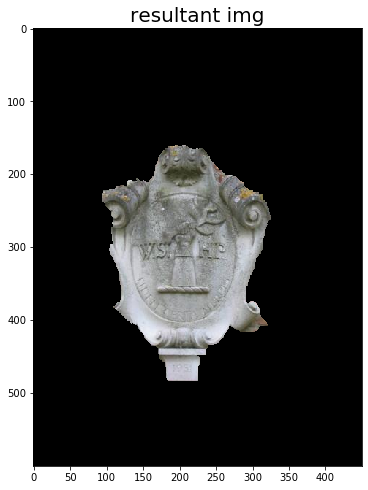

In [ ]:
if __name__ == '__main__':
    run('../img/', 'memorial.jpg', '../outs/', iters=1,gamma=50,k=5)
    cv2.destroyAllWindows()



In [8]:
img = cv2.imread("../img/memorial.jpg")

print(img.shape)
mask = np.zeros((img.shape[:2]), dtype=np.uint8)
gc = GrabCut(img, 50, 5, 10, (62, 146, 285, 372), mask, 1)



(600, 450, 3)
self.beta =  0.0011450310315646163


KeyboardInterrupt: 

In [ ]:
img[np.where(np.logical_or(gc.trimap == gc.BG,gc.trimap == gc.PR_BG ))] = [0, 0, 0]
x_start, y_start, x_end, y_end = gc.bgRect
x_end += x_start
y_end += y_start
print(x_start, y_start, x_end, y_end)
cv2.imshow('ss', img)
while True:
    k = cv2.waitKey(0) & 0xFF
    print(k)
    if k == 27:
        cv2.destroyAllWindows()
        break